<a href="https://www.kaggle.com/code/kenconstable/voting-stacking-ensemble-obesity-risk-0-91?scriptVersionId=163631805" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Ensemble Models to Predict Obesity Classification (0.91+ Accuracy)
The overall approach to this project was to train and optimize three individual models and evaluate two ensemble strategies

+ **Soft Voting Ensemble**: In this strategy, the model that was most confident in its classification prediction was selected. This evaluation is done at the observation level. The weighting of each individual model was optimized.
+ **Stacked Voting Ensemble**: In this strategy, the classification from each individual model is used as input into a 4th meta-learner model, which then makes its own classification.

The overall results show that the ensemble models performed better than each individual model, with the soft-voting ensemble outperforming the stacking ensemble method.

#### Feature Engineering
Several strategies were used to find features that could be used to exploit signals in the data, but not all of them worked.

+ One-Hot Encoding Categorial features => Gender,MTRANS,CAEC, and CALC
+ Standard Scaling of continuous features. While not strictly necessary when using decision tree models, it has been shown to boost performance in these competitions
+ Adding some feature interactions to group risk factors to help the model along
    + risk_bmi (body-mass-index)
    + risk_physical => physical activity
    + risk_consumption => number and size of meals, tracking consumption, etc.
    + risk_lifestyle => smoking and drinking

#### Class Imbalance
This dataset does not suffer from significant class imbalances. As such, so special methods were employed

#### Hyperparameter Tuning 
Hyperparameter tuning was done using Optuna to select parameter values that optimized the accuracy scores using cross-validation.

+ Individual Model Parameters (xgb, catboost, Light GBM)
+ Soft Voting Model Weights => to select the optimal weights of each individual model in the ensemble
+ lazypredict was used to search for the optimal meta-learner for the stacking ensemble

## Import Libraries and Configure Notebook

In [1]:
# %pip install lazypredict 

In [2]:
import gc
import numpy as np
import pandas as pd 

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go

# encoding and model evaluation
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score

# models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier, StackingClassifier

# optimization
import optuna
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_optimization_history


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants & Control Flow Variables
# ==================================================================
RANDOM = 1992

# Plotting
PLOT = True

# Optimization
TUNE = False

# Evalution  
EVALUATE, LAZY_PREDICT_EVAL = True, False

# Voting Type (hard or soft voting)
VOTE_TYPE = 'soft'

# Model Submission (only one should be positive)
STACK, VOTE, XGB, LGB, CAT = False, True, False, False, False

#### Ploting Theme
+ define the theme styles when using seaborn

In [3]:
# Color Palettes
colors = {
    "sage"     : "#53808D",
    "orange"   : "#FC4C02",
    "blue"     : "#1B99D6",
    "yellow"   : "#FFF57B",
    "darkgrey" : "#585858",
    "lightgrey": "#D5DADD",
    "lightsage": '#E9F2EF'
}
palette_discete = sns.color_palette([v for k,v in colors.items()])
palette_continuous = sns.color_palette(f"blend:{colors['sage']},{colors['orange']}", as_cmap=True) 

# custom theme
rc = {
    'axes.facecolor':f"{colors['lightsage']}",
    "axes.edgecolor":f"{colors['sage']}",
    "text.color":f"{colors['sage']}",
    "axes.labelcolor":f"{colors['sage']}",
    "ytick.color":f"{colors['sage']}",
    "xtick.color":f"{colors['sage']}",
}
sns.set_style('whitegrid',rc =rc)

# set context elements
sns.set_context('notebook',rc={'grid.linewidth':'1.1'})

# set custom palette
sns.set_palette(palette_discete)

palette_discete

[(0.3254901960784314, 0.5019607843137255, 0.5529411764705883),
 (0.9882352941176471, 0.2980392156862745, 0.00784313725490196),
 (0.10588235294117647, 0.6, 0.8392156862745098),
 (1.0, 0.9607843137254902, 0.4823529411764706),
 (0.34509803921568627, 0.34509803921568627, 0.34509803921568627),
 (0.8352941176470589, 0.8549019607843137, 0.8666666666666667),
 (0.9137254901960784, 0.9490196078431372, 0.9372549019607843)]

## Data Discovery

The attributes related to eating habits are: 
+ Frequent consumption of high-caloric food (FAVC)
+ Frequency of consumption of vegetables (FCVC)
+ Number of main meals (NCP)
+ Consumption of food between meals (CAEC) => Ordinal  (always, frequently, sometimes, no=never)
+ Consumption of water daily (CH20)
+ Consumption of alcohol (CALC) => Ordinal (frequently, sometimes, no=never)

The attributes related to the physical condition are: 
+ Calories consumption monitoring (SCC)
+ Physical activity frequency (FAF)
+ Time using technology devices (TUE)
+ Transportation used (MTRANS)

variables obtained
+ Gender
+ Age
+ Height
+ Weight

NObesity values are

+ Insufficient_Weight Less than 18.5
+ Normal_Weight 18.5 to 24.9
+ Overweight 25.0 to 29.9
+ Obesity_Type_I 30.0 to 34.9
+ Obesity_Type_II 35.0 to 39.9
+ Obesity_Type_III Higher than 40

#### Helper Functions: Data Aquisiton, Feature Engineering & Encoding
+ read the train and test csvs
+ include the original dataset, ensure there are no duplicates
+ adjust feature types
+ encode binary features

In [4]:
def get_data():
    """Read data from the csv, adjust data types"""
    train= pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
    test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
    original = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
    
    # category features 
    cols = ['Gender','CAEC','CALC','MTRANS','NObeyesdad']
    for col in cols:
        if col == 'NObeyesdad':
            # test data doesn't have NObeyesdad
            train[col] = train[col].apply(lambda x: x.strip()).astype('category')
            original[col] = original[col].apply(lambda x: x.strip()).astype('category')
        else:
            train[col] = train[col].apply(lambda x: x.lower().strip()).astype('category')
            test[col] = test[col].apply(lambda x: x.lower().strip()).astype('category')
            original[col] = original[col].apply(lambda x: x.lower().strip()).astype('category')
      
            
    # bindary features
    cols = ['family_history_with_overweight','FAVC','SMOKE','SCC']
    for col in cols:
        train[col] = train[col].map({'yes':1,'no':0}).astype('uint8')
        test[col] = test[col].map({'yes':1,'no':0}).astype('uint8')
        original[col] = original[col].map({'yes':1,'no':0}).astype('uint8')
        
    # rename columns
    train.rename(columns = {'family_history_with_overweight':'FamiliyHistory'},inplace=True)
    test.rename(columns = {'family_history_with_overweight':'FamiliyHistory'},inplace=True)
    original.rename(columns = {'family_history_with_overweight':'FamiliyHistory'},inplace=True)
    
    # add id to the oringal dataset, reorder to match the train/test data
    original['id'] = original.index
    original = original[train.columns.to_list()]
    
    # combine the original dataset with the train dataset, remove any duplicates
    train_and_original = (
         pd.concat([train, original],axis=0)
        .set_index('id')
        .drop_duplicates(ignore_index=True)
        .reset_index()
        .rename(columns={'index':'id'})
    )

    return train_and_original, test


# get the raw data
train, test = get_data()
gc.collect()
train.head()

,id,Gender,Age,Height,Weight,FamiliyHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,male,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,sometimes,0,2.763573,0,0.000000,0.976473,sometimes,public_transportation,Overweight_Level_II
1,1,female,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,frequently,0,2.000000,0,1.000000,1.000000,no,automobile,Normal_Weight
2,2,female,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,sometimes,0,1.910378,0,0.866045,1.673584,no,public_transportation,Insufficient_Weight
3,3,female,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,sometimes,0,1.674061,0,1.467863,0.780199,sometimes,public_transportation,Obesity_Type_III
4,4,male,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,sometimes,0,1.979848,0,1.967973,0.931721,sometimes,public_transportation,Overweight_Level_II


#### Add Additional Features
Add 4 risk features that are scored based on the survey data
+ risk_consumption
+ risk_activity
+ risk_lifestyle
+ risk_bmi

In [5]:
def add_features(df):
    """Add additional features"""
    def risk_consumption(row):
        """ consumption risk score"""
        # score
        risk = 0
        
        # consumption between meals (increases risk)
        d = {'always':2,'frequency':1}
        risk += d.get(row.CAEC,0)

        # number of main meals (median = 3)(increases risk)
        risk += row.NCP - 3.0

        # consumption of vegtables (median = 2.40 )(reduces risk)
        risk += 2.40 -row.FCVC

        # consumption of water (median = 2.0)(reduces risk)
        risk += 2.0 - row.CH2O
        
        # consumption of high caloric food(increases risk)
        risk += row.FAVC

        # caloric monitoring(decreases risk)
        risk -= row.SCC
        
        return risk
            
    def risk_activity(row):
        """activity risk score"""
        # score
        risk = 0
        
        # method of transportation (phyiscal activity reduces risk)
        d = {'walking':-1.0,'bike':-1.0}
        risk += d.get(row.MTRANS, 1.0)   
            
        # physical activity (median =1.0)(reduces risk)
        risk += 1.0 - row.FAF   
        
        return risk
    
    def risk_lifestyle(row):
        """lifestyle risk score"""
        risk = 0
        
        # consumption of alcohol (increases risk)
        d = {'always':2,'frequency':1,'no':-1}
        risk += d.get(row.CALC,0)

        # smoking (increases risk)
        risk += row.SMOKE
        return risk

    # copy the original
    dff = df.copy()
    
    # body-mass-index
    dff['risk_bmi'] = dff['Weight'] / dff['Height']**2
    
    # calculate the risk-factor
    dff['risk_consumption'] = dff.apply(lambda x: risk_consumption(x),axis=1)
    dff['risk_activity'] = dff.apply(lambda x: risk_activity(x),axis=1)
    dff['risk_lifestyle'] = dff.apply(lambda x: risk_lifestyle(x),axis=1)
    
    return dff

#### Encode / Decode the Target Variable
+ Need to label encode the target variable for classification, then decode back to the original for submission

In [6]:
def encode_target_variable(df,direction='encode'):
    """
    Encode the target variable to ordinal integers for classification
    Decode the target variable from ordinal integers back to string for submission
    """
    if direction=='encode':
        encode = {
            'Insufficient_Weight': 0,
            'Normal_Weight'      : 1,
            'Overweight_Level_I' : 2,
            'Overweight_Level_II': 3,
            'Obesity_Type_I'     : 4,
            'Obesity_Type_II'    : 5,
            'Obesity_Type_III'   : 6
        }
        encoded = df.NObeyesdad.map(encode).to_frame('Target')
        dff = pd.concat([df,encoded],axis=1)
    else:
        decode = {
            0:'Insufficient_Weight',
            1:'Normal_Weight'      ,
            2:'Overweight_Level_I' ,
            3:'Overweight_Level_II',
            4:'Obesity_Type_I'     ,
            5:'Obesity_Type_II'    ,
            6:'Obesity_Type_III'   
        }
        decoded = df.Target.map(decode).to_frame('NObeyesdad')
        dff = pd.concat([df,decoded],axis=1).drop(columns=['Target'])
    return dff

#### Helper Functions
+ Check the class balances after splitting into train/validation datasets
+ Segment features by types

In [7]:
def describe_train_test(y_train, y_test):
    """Check the train/test splits by class"""
        
    tn = pd.DataFrame(y_train.value_counts()).reset_index()
    tn['train_pct'] = round((tn['count']/tn['count'].sum())*100,2)
    tn.drop(columns=['count'],inplace=True)
    
    ts = pd.DataFrame(y_test.value_counts()).reset_index()
    ts['test_pct'] = round((ts['count']/ts['count'].sum())*100,2)
    ts.drop(columns=['count'],inplace=True)
    
    return tn.merge(ts, on='Target',how='inner').set_index('Target')    

In [8]:
def subset_features_by_type(df, include_types):
    """
    Filter columns of a pandas DataFrame based on specified data types.

    Parameters:
    df (pandas.DataFrame): DataFrame to filter
    include_types (list): List of data types to include in the filtered DataFrame.
        Valid values are: 'numeric', 'date', 'string', 'binary'

    Returns:
    filtered_df (pandas.DataFrame): DataFrame with only the columns that match
        the specified data types. If an error occurs, returns the original DataFrame
        with all columns.
    """
    # Map data types to numpy types
    type_map = {
        'numeric': np.number,
        'date': np.datetime64,
        'string': np.object_,
        'category': pd.CategoricalDtype,
        'binary': np.bool_,
        'float': np.float_,
        'int': np.int_
    }

    # Check if include_types is a valid list
    if not isinstance(include_types, list):
        include_types = [include_types]

    # Check if include_types contains valid data types
    for t in include_types:
        if t not in type_map:
            raise ValueError(f"Invalid data type: '{t}'")

    # Convert include_types to numpy types
    include_numpy_types = [type_map[t] for t in include_types]

    try:
        # Filter columns using select_dtypes
        return df.select_dtypes(include=include_numpy_types)
    except Exception as e:
        # If an error occurs, return the original DataFrame with all columns
        print(f"Error: {e}")
        return df

#### Add Features & Split into Train/Validation Datasets

In [9]:
# encode the target variable
train = encode_target_variable(train,'encode')

# add features
train = add_features(train)
test = add_features(test)

# test data is used for submission (does not include the Exited(y) variable)
X_submit_ids = test.id  # keep ids for later
X_submit = test.drop(columns = ['id'])

# train data
X = train.drop(columns=['Target','NObeyesdad']) # leave id until after train/test splits
y = train.Target

# split train data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM,stratify=y)

# keep the ids for lazy evaluation, then remove
X_train_ids = X_train.id
X_train.drop(columns =['id'],inplace=True)
X_test.drop(columns =['id'],inplace=True)
X.drop(columns =['id'],inplace=True)

# remove train/test
# del train
# del test
# gc.collect()

# describe train/test split
describe_train_test(y_train,y_test)

,train_pct,test_pct
Target,,
6,19.13,19.13
5,15.52,15.52
1,14.72,14.73
4,14.28,14.27
3,12.31,12.30
0,12.21,12.21
2,11.83,11.84


## Pipelines and Transformers
+ encode features
+ convert from arrays back to data frames after encoding. Not necessary, but makes plotting easier

In [10]:
def convert_to_df (transformed, processor):
    """Convert from array to dataframe after preprocessing the data"""
    df = pd.DataFrame(transformed)
    df.columns = processor.get_feature_names_out()
    return df
    

In [11]:
# numeric transformers
numeric_features = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE','risk_bmi','risk_lifestyle','risk_consumption','risk_activity']
numeric_transformer = Pipeline(
    steps = [('scaler',StandardScaler())]
)

# categorical encoders
category_features =  ['Gender','MTRANS','CAEC','CALC']
category_gender = ['male', 'female']
category_trans = ['public_transportation', 'automobile', 'walking', 'motorbike', 'bike']
category_scale = ['always','frequently','sometimes','no']
category_transformer = Pipeline(
    steps =[('onehot_encoder',OneHotEncoder(categories = [category_gender, category_trans, category_scale, category_scale]))]
)


# # ordinal features
# ordinal_features = ['CAEC','CALC']
# ordinal_feature_order = [['always','frequently','sometimes','no'],['always','frequently','sometimes','no']]
# ordinal_transformer = Pipeline(
#     steps =[('ordinal_encoder',OrdinalEncoder(categories = ordinal_feature_order))]
# )

# apply the column transforms
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer,numeric_features),
        ('cat',category_transformer,category_features),
    ],
    remainder = 'passthrough'
)


# prepare data for classification
X_array = preprocessor.fit_transform(X)
X_train_array = preprocessor.transform(X_train)
X_test_array = preprocessor.transform(X_test)
X_submit_array = preprocessor.transform(X_submit)

# convert to dataframes
X = convert_to_df(X_array,preprocessor)
X_train = convert_to_df(X_train_array,preprocessor)
X_test =  convert_to_df(X_test_array,preprocessor)
X_submit = convert_to_df(X_submit_array,preprocessor)


# clear memmory
gc.collect()

108

## Exploratory Data Analysis

#### Correlations

In [12]:
def plot_correlations(X_train, y_train, y_label, only_vs_target = True):
    """ Plot the correlations between features"""
    
    df_y = pd.DataFrame(y_train)
    df_y.columns = [y_label]
    
    # combine with input features
    df = pd.concat([X_train,df_y],axis=1)
    
    # calc the correlations
    c = df.corr().round(decimals=2)
    
    # subset to only show correlations with the target variable
    if only_vs_target:
        c = pd.DataFrame(c[y_label].sort_values()).T
        w = 1200
        h = 500
        title = "<b>Correlation of Features to Target</b>"
    else:
        w = 1000
        h = 1000
        title = "<b>Correlation of Features</b>"
    
    # plot the correlation matrix
    fig = px.imshow(
        c, 
        text_auto=True, 
        color_continuous_scale = 'RdYlbu',
        title = title,
        template = 'plotly_white',
        width = w,
        height= h,
    )
    fig.show()

In [13]:
if PLOT:
    plot_correlations(X, y, 'Target',True)

#### Pair Plots: Physical Factors
+ There are strong relationships between the target variable and physical attributes such as weight, height, bmi, and age

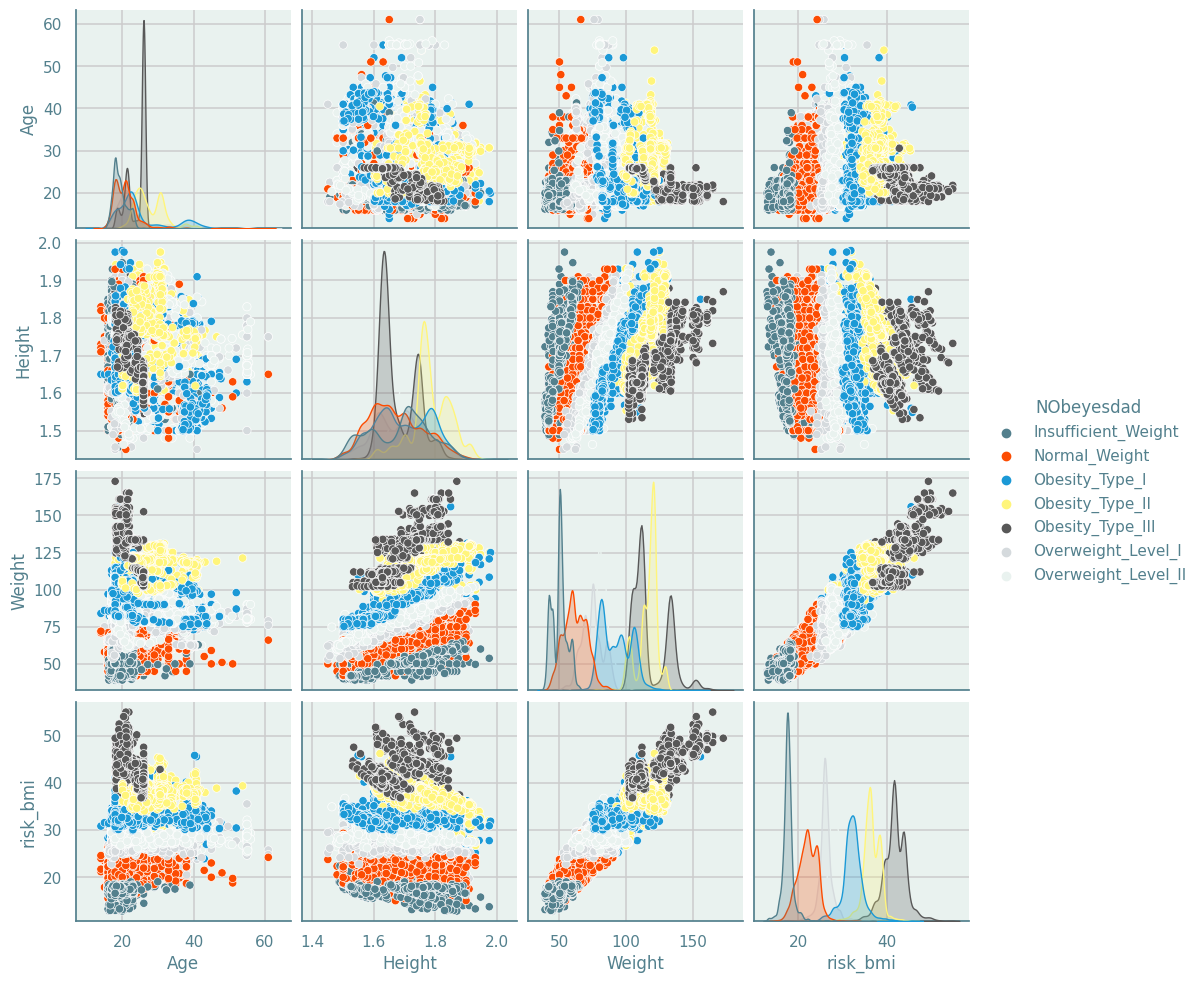

In [14]:
if PLOT:
    # physical factors
    numeric_features = ['Age','Height','Weight','risk_bmi','NObeyesdad']
    sns.pairplot(data = train[numeric_features],hue= 'NObeyesdad')
    

#### Pair Plots: Consumption Factors

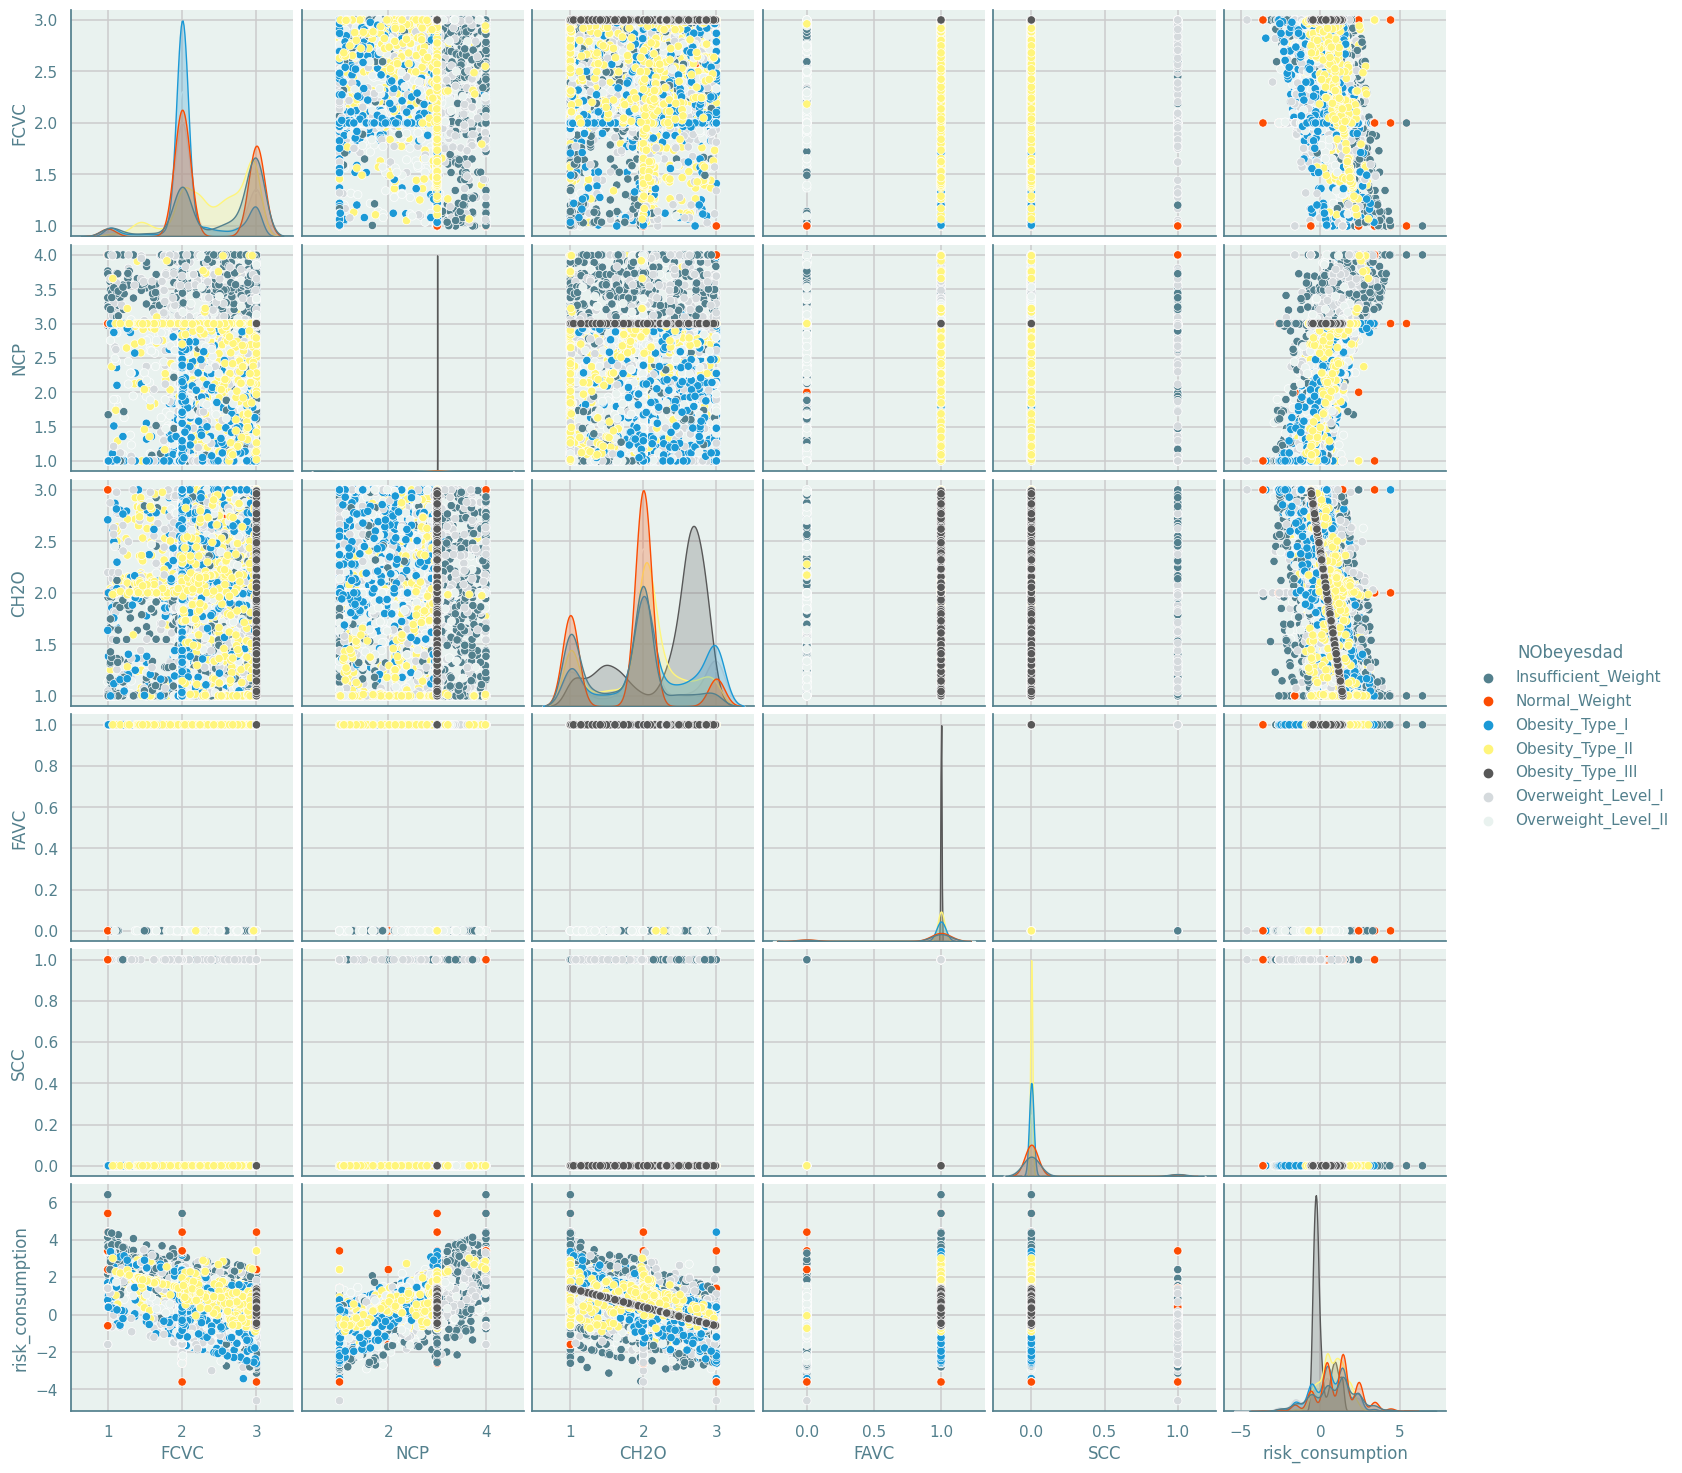

In [15]:
if PLOT:
    # consumption factors
    numeric_features = ['FCVC','NCP','CH2O','FAVC','SCC','risk_consumption','NObeyesdad']
    sns.pairplot(data = train[numeric_features],hue= 'NObeyesdad')

#### Risk Features vs Classification
+ The boxplots show strong relationships between classifications and risk_bmi, and to a lessor extent risk_consumption and risk_activity

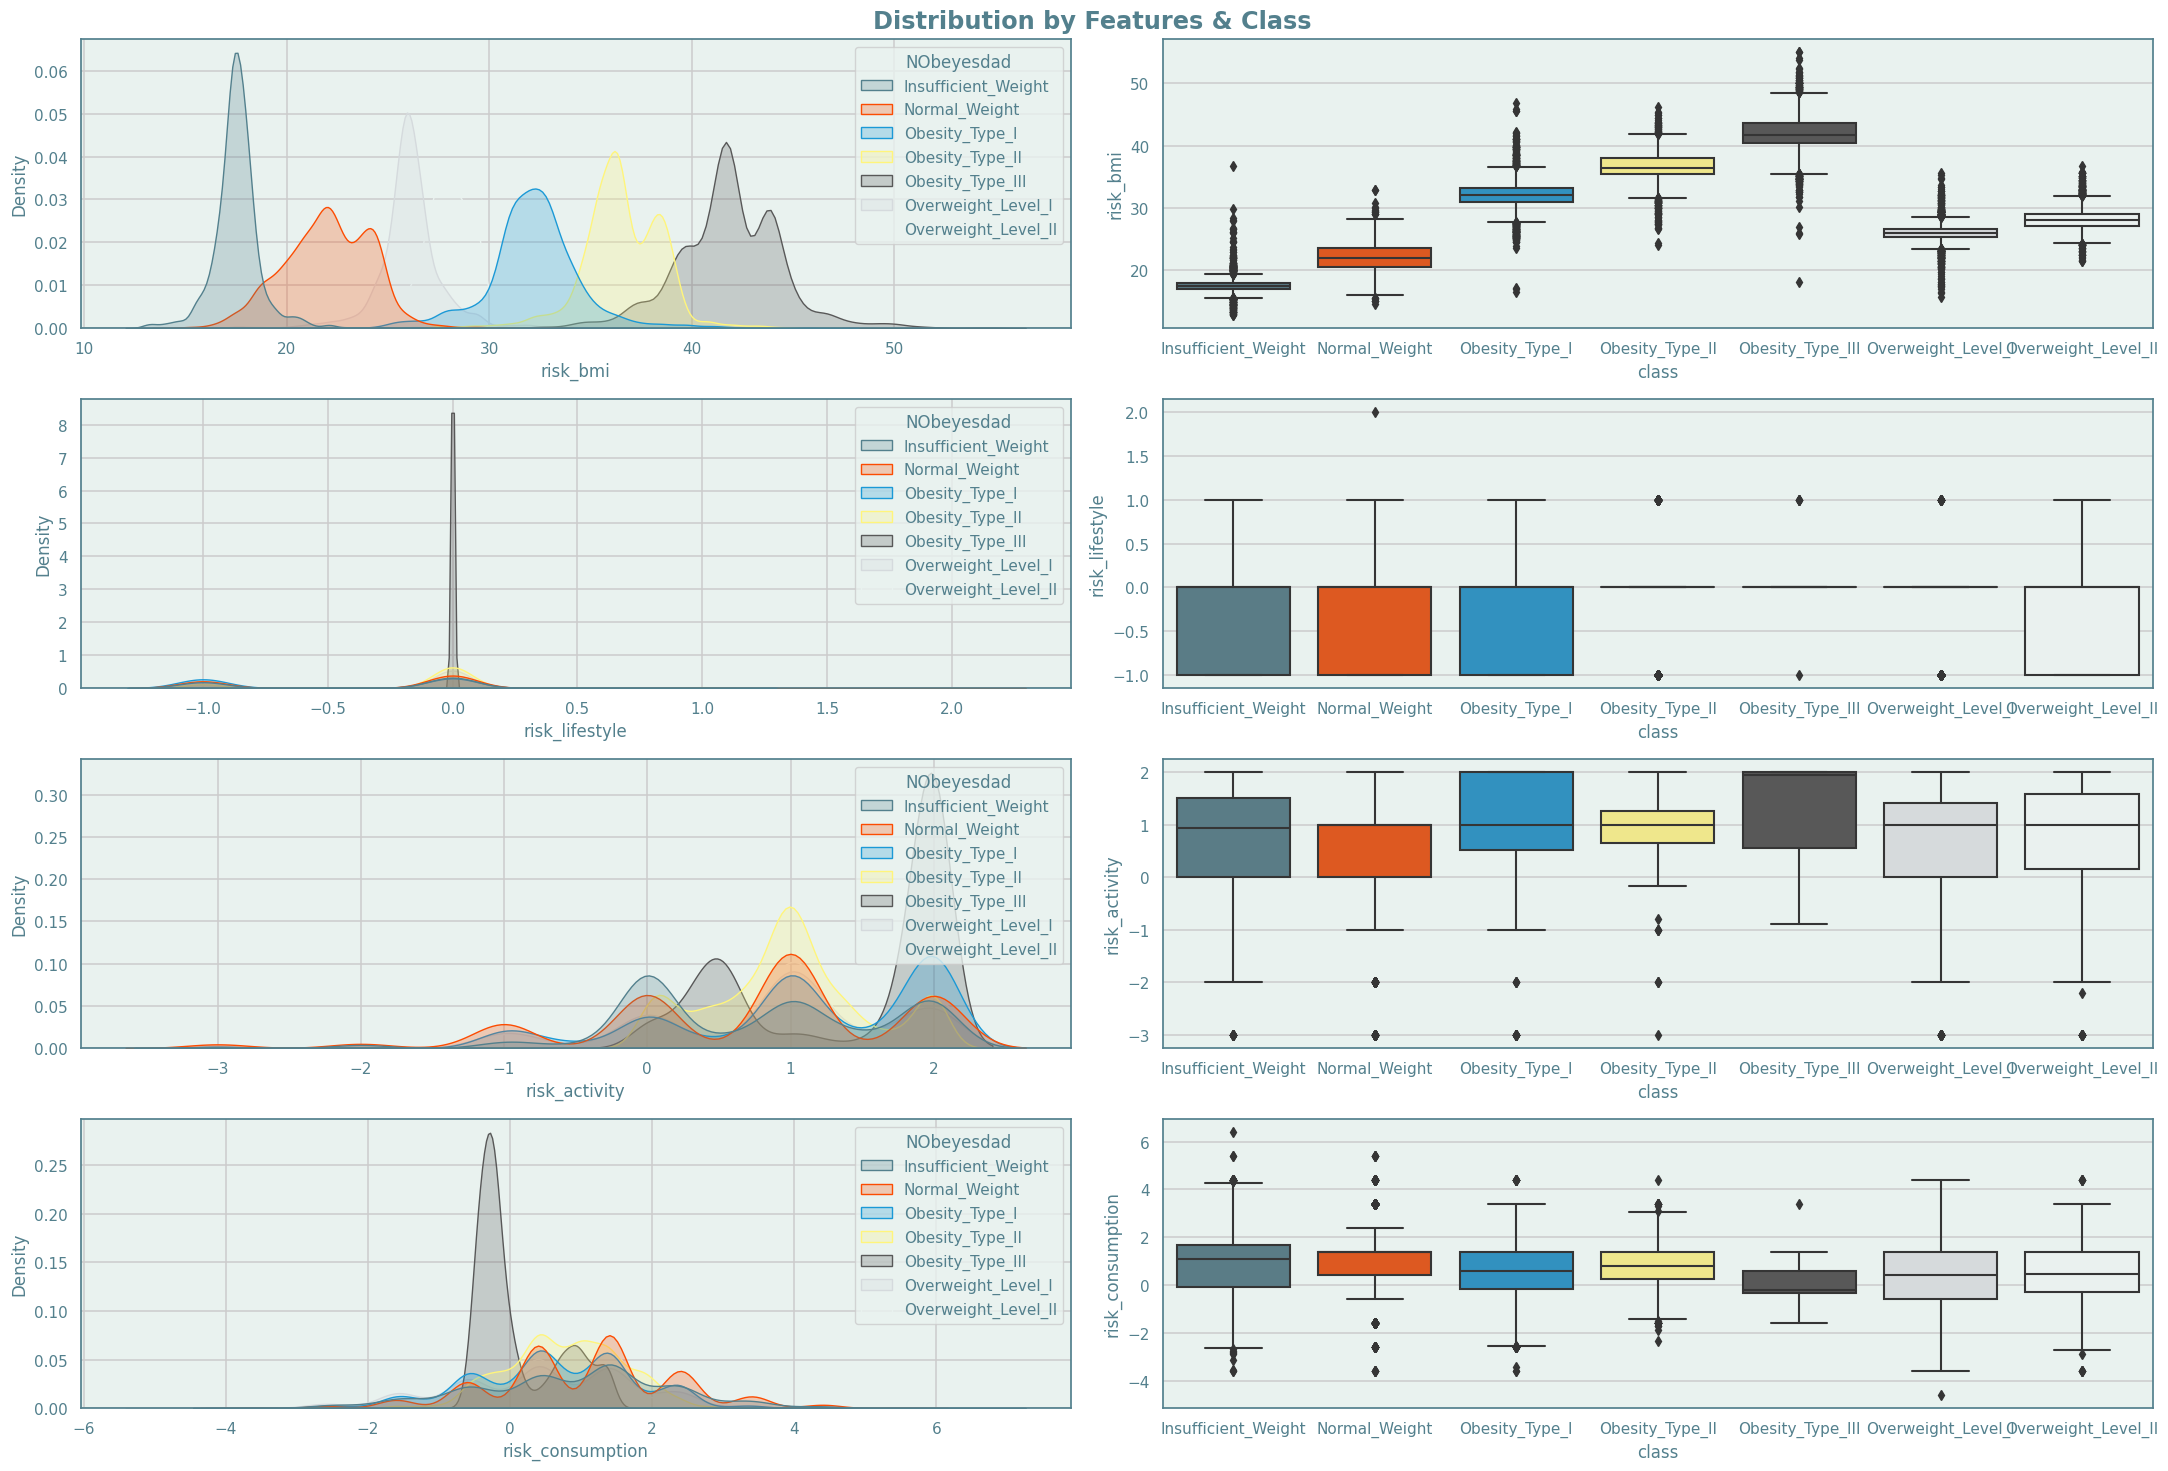

In [16]:
if PLOT:
    features = list(subset_features_by_type(train, 'float').columns)
    features = ['risk_bmi','risk_lifestyle','risk_activity','risk_consumption']

    fig, axs = plt.subplots(len(features),2,figsize=(22,15),gridspec_kw=dict(width_ratios=[4,4]))
    for row, feature in enumerate(features,0):
        sns.kdeplot(data = train, x=feature,hue='NObeyesdad',fill=True,warn_singular=False,ax=axs[row,0]).set_xlabel(feature)
        sns.boxplot(data=train, x='NObeyesdad',y=feature,ax=axs[row,1]).set_xlabel('class')

    # Title for the complete figure 
    fig.suptitle("Distribution by Features & Class" , fontsize = 'x-large' ,  fontweight = 'bold' ) 
    plt.tight_layout()

## Model Training
### Plotting & Evaluation Functions

In [17]:
def plot_training_metrics(model, model_type, metric='auc'):
    """
    Plot the evalution metric for train/validation datasets against each epoch
    Supports xgb, catboost and light gbm models
    """
    # extract train/validation results from the model
    if model_type == 'xgb':
        d = model.evals_result_
        t = d['validation_0'][metric]
        v = d['validation_1'][metric]
    elif model_type == "cat":
        d = model.evals_result_
        t = d["validation_0"][str(metric)]
        v = d["validation_1"][str(metric)]
    elif model_type == 'lgb':
        d = model.evals_result_
        t = d['training'][metric]
        v = d['valid_1'][metric]
        
    # convert to dataframe
    df_eval = pd.DataFrame(list(zip(t, v)), columns=["train", "val"])
    
    # create the plot
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_eval.index,
            y=df_eval.train,
            name="Training",
            line=dict(color=colors["sage"], width=2),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df_eval.index,
            y=df_eval.val,
            name="Validation",
            line=dict(color=colors["orange"], width=2),
        )
    )
    fig.update_layout(
        template="plotly_white",
        title=f"<b>Training Metrics: {metric.upper()}</b>",
        width=800,
        height=400,
    )
    fig.show()

In [18]:
def get_feature_importance(model, model_type, importance_type, normalize=True):
    """
    Extract the feature importance from a trained model
    model: trained  model
    model_type: model name (xgb, lgbm, cat)
    importance_type: weight, gain, cover (only applies to xgb)
    """

    # extract feature importance for each cv
    if model_type == "xgb":
        scores = model.get_booster().get_score(importance_type=importance_type)
        df = pd.DataFrame(dict(feature=scores.keys(),score=scores.values()))
    elif model_type == "lgb":
        # importance_type is set during model training=> importance_type='gain','split'
        names = model.feature_name_
        scores = model.feature_importances_
        df = pd.DataFrame(dict(feature=names,score=scores))
    elif model_type == "cat":
        # only weight is available. Gain requires that training dataset and is calculated post-training
        df = (
             model.get_feature_importance(prettified=True)
            .rename(columns={'Feature Id':'feature','Importances':'score'})
        )
    else:
        print(f"Model not recognized:{model_type} (get_feature_importances)")
        df = None
    
    # normalize the score out of 100%
    if normalize:
        df['score'] = df["score"] / df["score"].sum()
        
    # sort
    df.sort_values(by="score", ascending=True, inplace=True)
    
    return df

In [19]:
def plot_feature_importance(model, model_type, importance_type, normalize=True, top_n=None):
    """
    Plot a bar chart of feature importance
    Params:
        df_importance: a dataframe with the output from calc_feature_importance
    """
    # get feature importance
    df = get_feature_importance(model, model_type, importance_type, normalize)

    # filter by the top-n features & resort
    if top_n is not None:
        df = df.nlargest(top_n, "score")
        df.sort_values(by="score", ascending=True, inplace=True)

    # create plot
    fig = go.Figure()

    # create the plot of feature importance
    fig.add_trace(
        go.Bar(
            name="Importance",
            x=df.score,
            y=df.feature,
            orientation="h",
            marker=dict(color=colors["sage"]),
        )
    )
    fig.update_layout(
        title=f"<b>Feature Importance for the {model_type} model</b><br>Calculated using feature {importance_type}",
        template="plotly_white",
        width=500,
        height=500,
        yaxis=dict(type="category", tickmode="linear"),
    )
    fig.show()

In [20]:
def submit_predictions(ids, y_pred, decode=True,filename='submission.csv'):
    
    # assemble the submission data, decode the target variable back to strings
    df_submission = pd.DataFrame(zip(ids,y_pred),columns = ['id','Target'])
    
    # decode the classification
    if decode:
        df_submission = encode_target_variable(df_submission,'decode')
        df_submission.to_csv(f"/kaggle/working/{filename}",index=False)
    else:
        df_submission.to_csv(f"/kaggle/working/{filename}",index=False)


## Individual Models
### XGBoost
#### XGB Hyperparameter Tuning

In [21]:
def objective(trial):
    #XGB params to tune
    params = {
        'objective'        :'multi:softprob',
        'tree_method'      :'auto',
        'eval_metric'      :'mlogloss',
        'random_state'     : RANDOM,
        'n_estimators'     : trial.suggest_int('n_estimators',100,1000),
        'learning_rate'    : trial.suggest_loguniform('learning_rate', 0.01, 0.3),  
        'max_depth'        : trial.suggest_int('max_depth',3, 15),
        'min_child_weight' : trial.suggest_int('min_child_weight',2,20),
        'gamma'            : trial.suggest_float('gamma', 0, 1.0), 
        'subsample'        : trial.suggest_float('subsample', 0.5, 0.9), 
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 0.9), 
        'lambda'           : trial.suggest_float('lambda', 0.0, 3.0),
        'alpha'            : trial.suggest_float('alpha', 0.0, 3.0),
    }
    # model
    xgb = XGBClassifier(**params)

    # use stratified kfold to evalute each set of model weights
    skf= StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM)

    # Calculate the auc for each set of model weights
    acc = cross_val_score(xgb, X_train, y_train, cv=skf, scoring='accuracy').mean()
    
    return acc



if XGB and TUNE:
    # Optimize Hyperparameters
    # ===========================================================================================
    # create the study and run the optimization
    study = optuna.create_study(study_name='xgb-optimization',direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM))
    study.optimize(objective, n_trials=200)

    # get the best weights from the optimization
    xgb_best = study.best_params
    print(study.best_value)
    print(xgb_best)

    # clear some memmory
    gc.collect()
    
    # plot optimization
    plot_param_importances(study).show()
    plot_optimization_history(study).show()
    

#### XGBoost Evaluation

In [22]:
xgb_best = {
    'learning_rate'   : 0.022194625824361554,
    'max_depth'       : 5,
    'min_child_weight': 2,
    'gamma'           : 0.27910232830136383,
    'subsample'       : 0.620977387472603, 
    'colsample_bytree': 0.5305141740933788,
    'lambda'          : 0.2903510894985498, 
    'alpha'           : 0.22248261712836614,
    'objective'       :'multi:softprob',
    'tree_method'     :'auto',
    'eval_metric'     :'mlogloss',
    'random_state'    : RANDOM,
}

xgb_params = {
    'n_estimators'          : 892,
    'early_stopping_rounds' :75,
}
# train params
xgb_params.update(xgb_best)


if EVALUATE:
    # train
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train,  eval_set =[(X_train,y_train),(X_test,y_test)],verbose=0)

    # plot training metrics
    plot_training_metrics(xgb_model, 'xgb', 'mlogloss')

    # test on train data 
    y_pred = xgb_model.predict(X_test)

    # plot feature importance
    plot_feature_importance(xgb_model,'xgb','gain',True,15)

    # accuracy
    acc = accuracy_score(y_test,y_pred)
    print(f"Accuracy Score:{acc}")
    
    # export predictions for lazy prediction
    y_pred_on_train = xgb_model.predict(X_train)
    submit_predictions(X_train_ids, y_pred_on_train, decode=False,filename='xgb.csv')
    
    # clear some memmory
    gc.collect()

Accuracy Score:0.9131100897351718


#### XGBoost Submssion

In [23]:
if XGB:
    xgb_best = {
        'learning_rate'   : 0.022194625824361554,
        'max_depth'       : 5,
        'min_child_weight': 2,
        'gamma'           : 0.27910232830136383,
        'subsample'       : 0.620977387472603, 
        'colsample_bytree': 0.5305141740933788,
        'lambda'          : 0.2903510894985498, 
        'alpha'           : 0.22248261712836614,
        'objective'       :'multi:softprob',
        'tree_method'     :'auto',
        'eval_metric'     :'mlogloss',
        'random_state'    : RANDOM,
    }

    xgb_params = {
        'n_estimators'          : 892,
    }    
    
    # train params
    xgb_params.update(xgb_best)

    # train the model on all available data
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X,y,verbose=0)

    # predict on the test set
    y_pred = xgb_model.predict(X_submit)
    
    # export predictions for lazy evaluation
    submit_predictions(X_submit_ids, y_pred, decode=True,filename='submission.csv')
    print("XGB Model Submitted")


### Light GBM
#### LGBM Hyperparameter Tuning

In [24]:
def objective(trial):
    #LGB params to tune
    params = {
        'objective'           : 'multiclass',
        'boosting_type'       : 'gbdt',
        'random_state'        : RANDOM,
        'metric'              : "multi_logloss",
        'num_class'           : 7,
        "verbosity"           : -1,
        'n_jobs'              : -1,
        'n_estimators'        :trial.suggest_int('n_estimators',100,1000),
        'learning_rate'       : trial.suggest_loguniform('learning_rate', 0.01, 0.3),  
        'max_depth'           : trial.suggest_int('max_depth',3, 20),
        'min_child_samples'   : trial.suggest_int('min_child_samples',10,60),
        'num_leaves'          : trial.suggest_int('num_leaves', 30, 100), 
        'subsample'           : trial.suggest_float('subsample', 0.3, 0.9), 
        'colsample_bytree'    : trial.suggest_float('colsample_bytree', 0.3, 0.9), 
        'lambda_l1'           : trial.suggest_float('reg_lambda', 0, 3),
        'lambda_l2'           : trial.suggest_float('reg_alpha', 0, 3),
    }

    # model
    lgb = LGBMClassifier(**params)

    # use stratified kfold to evalute each set of model weights
    skf= StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM)

    # Calculate the auc for each set of model weights
    acc = cross_val_score(lgb, X_train, y_train, cv=skf, scoring='accuracy').mean()
    
    return acc

if LGB and TUNE:
    # Optimize Hyperparameters
    # ===========================================================================================
    # create the study and run the optimization
    study = optuna.create_study(study_name = 'lgb-optimization',direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM))
    study.optimize(objective, n_trials=200)

    # get the best weights from the optimization
    lgb_best = study.best_params
    print(study.best_value)
    print(lgb_best)

    # clear some memmory
    gc.collect()
    
    # plot optimization
    plot_param_importances(study).show()
    plot_optimization_history(study).show()

#### LightGBM Evaluation

In [25]:
lgb_best = {
    'learning_rate'     : 0.01183503431690636, 
    'max_depth'         : 19,
    'min_child_samples' : 49, 
    'num_leaves'        : 60, 
    'subsample'         : 0.6552328150821255,
    'colsample_bytree'  : 0.33380901796097023, 
    'reg_lambda'        : 0.0916412992420405,
    'reg_alpha'         : 2.3817819457451836,
    "objective"         : "multiclass",
    "metric"            : "multi_logloss",
    "num_class"         : 7,
    "verbosity"         : -1,
    "boosting_type"     : "gbdt",
    "random_state"      : RANDOM,
}

lgb_params = {
    'n_estimators'          : 969,
    'early_stopping_rounds' :75
}
lgb_params.update(lgb_best)

if EVALUATE:
    lgb_model = LGBMClassifier(**lgb_params)
    lgb_model.fit(X_train, y_train,  eval_set =[(X_train,y_train),(X_test,y_test)])

    # plot training metrics
    plot_training_metrics(lgb_model, 'lgb', 'multi_logloss')

    # test on train data 
    y_pred = lgb_model.predict(X_test)

    # plot feature importance
    plot_feature_importance(lgb_model,'lgb','weight',True, 15)

    # accuracy
    acc = accuracy_score(y_test,y_pred)
    print(f"Accuracy Score:{acc}")
    
    # export predictions for lazy evaluation
    y_pred_on_train = lgb_model.predict(X_train)
    submit_predictions(X_train_ids, y_pred_on_train, decode=False,filename='lgb.csv')

    # clear some memmory
    gc.collect()


Accuracy Score:0.9100459619172685


#### LightGBM Submssion

In [26]:
if LGB:
    lgb_best = {
    'learning_rate'     : 0.01183503431690636, 
    'max_depth'         : 19,
    'min_child_samples' : 49, 
    'num_leaves'        : 60, 
    'subsample'         : 0.6552328150821255,
    'colsample_bytree'  : 0.33380901796097023, 
    'reg_lambda'        : 0.0916412992420405,
    'reg_alpha'         : 2.3817819457451836,
    "objective"         : "multiclass",
    "metric"            : "multi_logloss",
    "num_class"         : 7,
    "verbosity"         : -1,
    "boosting_type"     : "gbdt",
    "random_state"      : RANDOM,
    }
    
    lgb_params = {
        'n_estimators': 969,
    }
    lgb_params.update(lgb_best)


    # train the model on all available data
    lgb_model = LGBMClassifier(**lgb_params)
    lgb_model.fit(X,y)

    # predict on the test set
    y_pred = lgb_model.predict(X_submit)
    
    # export predictions for lazy evaluation
    submit_predictions(X_submit_ids, y_pred, decode=True,filename='submission.csv')
    print("LGBM Model Submitted")


### Catboost
#### Catboost Hyperparameter Tuning

In [27]:
def objective(trial):
    #Catboost params to tune
    params = {
        'loss_function'       : 'MultiClass',
        'verbose'             : 0 ,
        'random_seed'         : RANDOM,
        'n_estimators'        : trial.suggest_int('iterations', 100, 1000),
        'learning_rate'       : trial.suggest_loguniform('learning_rate', 0.01, 0.3),  
        'depth'               : trial.suggest_int('depth',3, 12),
        'min_data_in_leaf'    : trial.suggest_int('min_data_in_leaf',5,20),
        'l2_leaf_reg'         : trial.suggest_int('l2_leaf_reg', 2, 10), 
        'bagging_temperature' : trial.suggest_int('bagging_temperature', 2, 10), 
        'random_strength'     : trial.suggest_float('random_strength', 0.2, 0.9), 
        'colsample_bylevel'   : trial.suggest_float('colsample_bylevel', 0.3, 0.9),
        'border_count'        : trial.suggest_int('border_count', 32, 255),
    }
    # model
    cat = CatBoostClassifier(**params)

    # use stratified kfold to evalute each set of model weights
    skf= StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM)

    # Calculate the auc for each set of model weights
    acc = cross_val_score(cat, X_train, y_train, cv=skf, scoring='accuracy').mean()
    
    return acc

if CAT and TUNE:
    # Optimize Hyperparameters
    # ===========================================================================================
    # create the study and run the optimization
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM))
    study.optimize(objective, n_trials=150)

    # get the best weights from the optimization
    cat_best = study.best_params
    print(study.best_value)
    print(cat_best)
    gc.collect()
    
    # plot optimization
    plot_param_importances(study).show()
    plot_optimization_history(study).show()

#### Catboost Evaluation

In [28]:
# Cat Evaluation
cat_best = {
    'learning_rate'      : 0.20178944678915414,
    'depth'              : 5, 
    'min_data_in_leaf'   : 10, 
    'l2_leaf_reg'        : 8, 
    'bagging_temperature': 2, 
    'random_strength'    : 0.5505115932357647, 
    'colsample_bylevel'  : 0.8000128297809009, 
    'border_count'       : 221,
    'random_seed'        : RANDOM,
    'verbose'            : 0
}

cat_params = {
    'n_estimators'          : 900,
    'early_stopping_rounds' : 75
}
cat_params.update(cat_best)

if EVALUATE:
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_train, y_train,  eval_set =[(X_train,y_train),(X_test,y_test)])

    # plot training metrics
    plot_training_metrics(cat_model, 'cat', 'MultiClass')

    # test on train data 
    y_pred = cat_model.predict(X_test)

    # accuracy
    acc = accuracy_score(y_test,y_pred)
    print(f"Accuracy Score:{acc}")

    # plot feature importance
    plot_feature_importance(cat_model,'cat','weight',True,15)
    
    # export predictions for lazy evaluation
    y_pred_on_train = cat_model.predict(X_train)
    y_pred_on_train = [p[0] for p in y_pred_on_train]
    submit_predictions(X_train_ids, y_pred_on_train, decode=False,filename='cat.csv')

    # clear some memmory
    gc.collect()

Accuracy Score:0.912015758371635


#### Catboost Submission

In [29]:
# submmit single cat model
if CAT:
    cat_best = {
        'learning_rate'      : 0.20178944678915414,
        'depth'              : 5, 
        'min_data_in_leaf'   : 10, 
        'l2_leaf_reg'        : 8, 
        'bagging_temperature': 2, 
        'random_strength'    : 0.5505115932357647, 
        'colsample_bylevel'  : 0.8000128297809009, 
        'border_count'       : 221,
        'random_seed'        : RANDOM,
        'verbose'            : 0
    }

    cat_params = {
        'n_estimators': 639,
    }
    cat_params.update(cat_best)

    # train the model on all available data
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X,y,verbose=0)

    # predict on the test set
    y_pred = cat_model.predict(X_submit)
    y_pred = [p[0] for p in y_pred]
    
    # export predictions for lazy evaluation
    submit_predictions(X_submit_ids, y_pred, decode=True,filename='submission.csv')
    print("Catboost Model Submitted")

## Ensemble Methods
+ some helper functions to create and evalute ensemble models

In [30]:
def get_voting_ensemble_models(models, vote_type, weights=None):
    """Create a dictionary of individual models + a voting ensemble model"""
    d = dict()
    for model in models:
        d[model[0]] = model[1]
    
    # add the ensembles
    if vote_type == 'soft':
        d['ensemble_soft'] =  VotingClassifier(estimators=models, voting='soft', weights=weights,verbose=False)
    else:
        d['ensemble_hard'] =  VotingClassifier(estimators=models, voting='hard', verbose=False)
    return d  


def get_stacked_ensemble_models(base_learners, meta_learner, method='predict'):
    """Create a dictionary of individual models + a meta learner for a stacked ensemble evaluation
    method: predict or predict_proba
    """
    
    # stack the ensemble
    ensemble_stacked = StackingClassifier(
        estimators=base_learners, 
        final_estimator=meta_learner, 
        stack_method=method
    )
    
    # return the models in a dict
    d=dict()
    for learner in base_learners:
        d[learner[0]] =  learner[1]
    d['ensemble_stacked'] = ensemble_stacked
    
    return d


def evaluate_model(model, eval_metric, n_splits, n_repeats, random, X, y):
    """ Use repeated stratified kfold to evaluate model performance"""
    # define the cv
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random)
    scores = cross_val_score(model, X, y, scoring=eval_metric, cv=cv, n_jobs=-1)
    return scores, cv


def evaluate_ensemble(models, eval_metric, n_splits, n_repeats, random, X, y):
    """Use repeated stratified kfold process to evaluate model performance for multiple models and ensembles"""
    print("Repeated Stratified Kfold Training")
    print("="*100)
    results = dict()
    for model_name, model in models.items():
        scores, cv = evaluate_model(model, eval_metric, n_splits, n_repeats, random, X, y)
        results[model_name] = scores
        print(f"=> {model_name} (average {eval_metric}) = {round(np.mean(scores),4)} ")

    # show boxplots of the results
    print("="*100)
    plot_evalmetric_boxplots(results,eval_metric)
    
    return results,cv


def plot_evalmetric_boxplots(results, metric):
    """Plot boxplots of model results for the eval-metric"""
    
    fig = go.Figure()
    for model,metrics in results.items():
        color = colors['orange'] if ('ensemble' in model) or ('stacked' in model) else colors['sage']
        fig.add_trace(
            go.Box(y=metrics,name=model,boxpoints='all',jitter=0.3,marker=dict(color=color))
        )
    fig.update_layout(template='plotly_white',title=f'<b>Training Results:</b> {metric}',height=500,width=500,showlegend=False)
    fig.show()

### Meta Learner Evaluation using Lazy Predict Classifier 
+ This script was used to find the best meta-learner for the stacked ensemble model
+ The script grabs the classifications from each individual model then uses lazypredict to evaluate all the scikit learn classification models
+ I selected GaussianNB as it had good performance and fast training time


### Stacked Ensemble

In [31]:
if LAZY_PREDICT_EVAL:

    import lazypredict
    from lazypredict.Supervised import LazyClassifier
    
    
    # get the invidual model predictions
    for i,file in enumerate(['xgb','lgb','cat']):
        df_tmp = (
             pd.read_csv(f'/kaggle/working/{file}.csv')
            .rename(columns={'Target':file})
            .set_index('id')
        )
        if i==0:
            X_train_meta = df_tmp.copy()
        else:
            X_train_meta = X_train_meta.join(df_tmp)


    # split train data into train/test for lazy predict
    X_train_lazy, X_test_lazy, y_train_lazy, y_test_lazy = train_test_split(X_train_meta, y_train, test_size=0.20, random_state=RANDOM,stratify=y_train)

    # lazy predict classifer 
    clf = LazyClassifier(
        verbose=0, 
        ignore_warnings=True, 
        predictions=True, 
        custom_metric=None,
        random_state = RANDOM
    )
    models, predictions = clf.fit(X_train_lazy,X_test_lazy, y_train_lazy, y_test_lazy)
    
    # garbage collect
    gc.collect()
    
    # display the evaluation results
    models

#### Evaluate the Stacked Ensemble Model

In [32]:
if STACK and EVALUATE:
    
    # update parameters for evaluation
    lgb_params = {'n_estimators' : 969}
    lgb_params.update(lgb_best)
    
    cat_params = {'n_estimators': 639}
    cat_params.update(cat_best)
    
    xgb_params = {'n_estimators': 892}
    xgb_params.update(xgb_best)

    # define individual models
    xgb = XGBClassifier(**xgb_params)
    lgb = LGBMClassifier(**lgb_params)
    cat = CatBoostClassifier(**cat_params)

    # list of models to evaluate individually and in an ensemble
    base_learners = [('lgb',lgb),('xgb', xgb),('cat',cat)]

    # define the meta-learner
    meta_learner = GaussianNB() 


    # define the individual models and the ensemble
    models = get_stacked_ensemble_models(base_learners,meta_learner,'predict')

    # train the ensemble
    results,cv = evaluate_ensemble(models, 'accuracy', 3,1, RANDOM, X_test,y_test)
    
# Evaluation Accuracy
# stacked Guassian 0.9005


### Voting Ensemble
#### Hypertune Ensemble Weights

In [33]:
def objective(trial):
    weights = [
        trial.suggest_float('weight_xgb', 0, 1),  
        trial.suggest_float('weight_lgb', 0, 1),
        trial.suggest_float('weight_cat', 0, 1)
    ]
    # set up the ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb),
            ('lgb', lgb),
            ('cb', cat)
        ], voting='soft', weights=weights)
    
    # use stratified kfold to evalute each set of model weights
    skf= StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM)

    # Calculate the auc for each set of model weights
    acc = cross_val_score(ensemble, X, y, cv=skf, scoring='accuracy').mean()

    return acc

if VOTE and TUNE:
    # Optimize Soft Voting Model Weights
    # ===============================================================================================
    # update parameters for evaluation
    lgb_params = {'n_estimators' : 969}
    lgb_params.update(lgb_best)

    cat_params = {'n_estimators': 639}
    cat_params.update(cat_best)

    xgb_params = {'n_estimators': 892}
    xgb_params.update(xgb_best)

    # define individual models
    xgb = XGBClassifier(**xgb_params)
    lgb = LGBMClassifier(**lgb_params)
    cat = CatBoostClassifier(**cat_params)


    # create the study and run the optimization
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM))
    study.optimize(objective, n_trials=75)


    # get the best weights from the optimization
    optimal_weights = study.best_params
    print(optimal_weights)
    gc.collect()

#### Evaluate Voting Ensemble

In [34]:
# voting evaluation
if VOTE and EVALUATE:
    
    # update parameters for evaluation
    lgb_params = {'n_estimators' : 969}
    lgb_params.update(lgb_best)
    
    cat_params = {'n_estimators': 639}
    cat_params.update(cat_best)
    
    xgb_params = {'n_estimators': 892}
    xgb_params.update(xgb_best)

    # define individual models
    xgb = XGBClassifier(**xgb_params)
    lgb = LGBMClassifier(**lgb_params)
    cat = CatBoostClassifier(**cat_params)


    # define the individual models and the ensemble
    if VOTE_TYPE == 'soft':
        models_lst = [('lgb',lgb),('xgb', xgb),('cat',cat)]
        optimal_weights = [0.8906033870764647,0.702778860161278, 0.7097786284390253] 
        models = get_voting_ensemble_models(models_lst,'soft', optimal_weights) 
    else:
        models_lst = [('lgb',lgb),('xgb', xgb)] # cat doesn't work with hard voting
        optimal_weights = [0.8906033870764647,0.702778860161278]  # can't be uniform with two models...
        models = get_voting_ensemble_models(models_lst,'hard', optimal_weights) 
        

    # train the ensemble
    results,cv = evaluate_ensemble(models, 'accuracy', 3,3, RANDOM, X_train,y_train)

    # Accuracy
    # 0.9137 


Repeated Stratified Kfold Training
=> lgb (average accuracy) = 0.914 
=> xgb (average accuracy) = 0.9143 
=> cat (average accuracy) = 0.908 
=> ensemble_soft (average accuracy) = 0.9136 


## Submissions

In [35]:
if STACK:
    # update parameters for evaluation
    lgb_params = {'n_estimators' : 969}
    lgb_params.update(lgb_best)
    
    cat_params = {'n_estimators': 639}
    cat_params.update(cat_best)
    
    xgb_params = {'n_estimators': 892}
    xgb_params.update(xgb_best)
    
    
    # define individual models with their optimized parameters
    xgb = XGBClassifier(**xgb_params)
    lgb = LGBMClassifier(**lgb_params)
    cat = CatBoostClassifier(**cat_params)

    # base learners
    base_learners = [('lgb',lgb),('xgb', xgb), ('cat', cat)]

    # meta learner
    meta_learner = GaussianNB()

    # stacked ensemble
    ensemble_stacked = StackingClassifier(
        estimators=base_learners, 
        final_estimator=meta_learner, 
        stack_method='predict', 
        passthrough=False,
        n_jobs = -1
    )
    # fit the model on all available data
    ensemble_stacked.fit(X,y)

    # predict on the submission dataset,decode the classes and save the csv
    y_pred = ensemble_stacked.predict(X_submit)
    
    # submission
    submit_predictions(X_submit_ids, y_pred, decode=True,filename='submission.csv')
    print("Stacked Ensembled Submitted")

    gc.collect()

In [36]:
if VOTE:
    # update parameters for evaluation
    lgb_params = {'n_estimators' : 969}
    lgb_params.update(lgb_best)
    
    cat_params = {'n_estimators': 639}
    cat_params.update(cat_best)
    
    xgb_params = {'n_estimators': 892}
    xgb_params.update(xgb_best)
    
    # define individual models
    xgb = XGBClassifier(**xgb_params)
    lgb = LGBMClassifier(**lgb_params)
    cat = CatBoostClassifier(**cat_params)

    # list of models to evaluate individually and in an ensemble
    models_lst = [('lgbm', lgb), ('xgb', xgb),('cat',cat)]
    optimal_weights = [0.8906033870764647,0.702778860161278, 0.7097786284390253] 

    # Soft voting ensemble
    ensemble = VotingClassifier(estimators=models_lst, voting=VOTE_TYPE, weights=optimal_weights,verbose=False)
    ensemble.fit(X,y)
    
    # predict on the submission dataset,decode the classes and save the csv
    y_pred = ensemble.predict(X_submit)

    # submission
    submit_predictions(X_submit_ids, y_pred, decode=True,filename='submission.csv')
    print("Voting Ensembled Submitted")

    gc.collect()

Voting Ensembled Submitted
